# Applying Machine Learning Models

In [136]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [137]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])


print(df_concat.shape)

(9233, 642)


In [138]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

print(len(features_act))
# print(features_uid)

640


In [139]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [140]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [141]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(7, 7))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [142]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [143]:
labels_act = ['WALKING', 'WALKING\nUPSTAIRS', 'WALKING\nDOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [144]:
n = 119
# f_add_weighted_noise = set()
# for f in features_uid[:n]:
#   f_add_weighted_noise.add(f)
# print(f_add_weighted_noise)

# n = 211
f_add_weighted_noise = set()
for f in features_uid[:n]:
  # 重複していないものを入れる
  if f not in features_act[:n]:
    f_add_weighted_noise.add(f)
print(len(f_add_weighted_noise))

83


In [145]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]
weighted_epsilon = weighted_epsilon_array[1]

## 2. Random Forest Classifier

## UID

In [146]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_uid = list()
f1_array_random_uid = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
epsilons = [1.2, 1.3]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  
  params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  f1_array_random_uid.append(f1)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  
  #print(rfc_grid_results['confusion_matrix'])
  #print(rfc_grid_results["classification_report"])
  # observe the attributes of the model 
  # print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_uid)

--------
epsilon:  1.2
--------


KeyboardInterrupt: 

## HAR

--------
epsilon:  1.2
--------
training the model...
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Done
==> training time:- 0:12:34.274500

Predicting test data
==> testing time:- 0:00:00.088808

==> Accuracy:- 0.6386609780111585


 ********Confusion Matrix********

 [[412  43  75   0  11   0]
 [238 192  50   4   7   1]
 [111  44 270   1   1   1]
 [  0   1   0 109 333  63]
 [  1   0   0  75 437  20]
 [  0   0   0   9  12 526]]


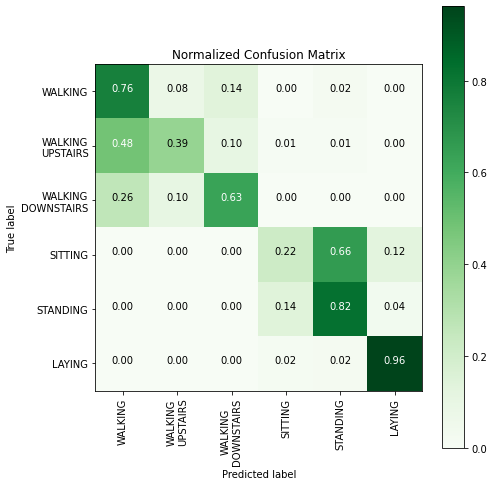

****************| Classifiction Report |****************

 F1 Score:0.6098710975528304
[[412  43  75   0  11   0]
 [238 192  50   4   7   1]
 [111  44 270   1   1   1]
 [  0   1   0 109 333  63]
 [  1   0   0  75 437  20]
 [  0   0   0   9  12 526]]
              precision    recall  f1-score   support

         1.0       0.54      0.76      0.63       541
         2.0       0.69      0.39      0.50       492
         3.0       0.68      0.63      0.66       428
         4.0       0.55      0.22      0.31       506
         5.0       0.55      0.82      0.66       533
         6.0       0.86      0.96      0.91       547

    accuracy                           0.64      3047
   macro avg       0.64      0.63      0.61      3047
weighted avg       0.64      0.64      0.61      3047

--------
epsilon:  1.3
--------
training the model...
Fitting 10 folds for each of 35 candidates, totalling 350 fits


KeyboardInterrupt: 

In [148]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_har = list()
f1_array_random_har = list()

epsilons = [1.2, 1.3]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  # for feature in f_add_weighted_noise:
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  
  params = {'n_estimators': np.arange(150,211,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  f1_array_random_har.append(f1)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  
  print(rfc_grid_results['confusion_matrix'])
  print(rfc_grid_results["classification_report"])
  # observe the attributes of the model 
  # print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_har)

In [ ]:
# epsilons = [1.2, 1.3, 2.5, 2.6, 2.7, 2.8]
print(f1_array_random_har)
print(f1_array_random_uid)
print(acc_array_random_har)
print(acc_array_random_uid)

print((0.7213523559678895+.7116229273358777)/2)
# 0.7213523559678895
# 0.6995180943310659
# 0.7116229273358777

[0.3799816529451814, 0.5442759294459615]
[0.01749748117067078, 0.01266467171381654]
[0.44338693797177553, 0.5868066951099442]
[0.036101083032490974, 0.035116508040695764]
0.7164876416518836


In [ ]:
print(weighted_epsilon)
print(n)
print(epsilons)

0.001
119
[0.5, 0.9]


In [ ]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [ ]:
beep()

ModuleNotFoundError: No module named 'google.colab'